---
title: "Index Tracking: a naive approach"
author: "Alejandro Pérez Sanjuán"
date: 2024-07-28
categories: [finance, analysis, python, index tracking]
format: html
---

We review in this post a naive approach to solve the Index Tracking problem using Principal Component Analysis.

## 1. Introduction

A financial index is a number that represents the aggregate value of a group of items. In particular, a financial index is composed of a collection of assets, such as stocks or bonds (each instrument associated with a weight that determines its importance on the overall basket), which captures the value of a specific market or a segment of it (Benidis, K., Feng, Y., & Palomar, D. P. (2018)).

Index tracking is a well-known problem in passive investment that consists in designing a portfolio, called tracking portfolio, that closely follows a benchmark index. Usually, the tracking portfolio is constructed using a subset of the original financial instruments that compose the index.

### 1.1. Tracking Error
To measure the goodness of a tracking portfolio with respect to the index we use the *tracking error* (TE). The TE is usually defined as the standard deviation of the difference between the returns of the tracking portfolio and the returns of the index

$$
TE = Std(r_{index} - r_{tracking}),
$$

where $r_{index}$ are the returns of the index and $r_{tracking}$ are the returns of the tracking portfolio, defined as

$$
r_{tracking}=\sum_{i}^{k} w_{i} \cdot r_{i}.
$$

Here, $w_{i}$ and $r_{i}$ are the weights and returns of asset $i$ and $k$ is the number of assets in the tracking portfolio.

## 2. Methodology

### 2.1. Principal component Analysis
Principal Component Analysis (PCA) is a statistical technique that allows expressing a set of variables as a set of linearly uncorrelated variables called principal components. We are not going to dive into the definition and computations needed to perform PCA. Instead, we are going to focus on using this technique to select a subset of relevant instruments, from the total amount of instruments that compose and index, to construct a tracking portfolio.

### 2.2. Dataset

We work in this post with the adjusted close prices of SP500 constituents, downloaded from Yahoo finance on date 2024-05-30. Survivorship bias has not been taken into account and that is why some tickers may be missing. In any case, this is not important for the objective of the post.

Whenever we work with the dataset, we discard the tickers that have any missing values in the lookback period.

## 3. Results

We apply in this section the PCA-based index tracking methodology to the SP500. The idea is to generate a portfolio of size $k$ every month. In actual fact, we are not truly rebalancing because we are not going to take into account the previous portfolio. We are also not going to take into account weight drift (or style drift) since we are not considering neither working with shares nor with a budget.

The following cells load the SP500 component prices and the index itself. Then, we compute the relative returns.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA

In [15]:
dataset = pd.read_csv("data/sp500.csv", index_col=0)
dataset.index = pd.DatetimeIndex(dataset.index)

# the index is the last column
components = dataset.iloc[:, :-1]
index = dataset.iloc[:, -1:]

asset_returns = components.pct_change()
index_returns = index.pct_change().squeeze()

In [16]:
def get_portfolio_weights(
    asset_returns,
    computation_date,
    portfolio_size,
    lookback=pd.offsets.BusinessDay(252 * 2)
):
    """Compute portfolio weights using PCA for a given portfolio size.

    Returns are standardized using "lookback" periods, and the portfolio is
    constructed by selecting the weights on the assets that contribute the most
    to the variance.

    Parameters
    ----------
    asset_returns : pandas.DataFrame
        Pandas DataFrame containing the returns of the instruments that compose
        the index.
    computation_date : pandas.Timestamp
        Date at which to perform the portfolio construction.
    portfolio_size : int
        Number of non-zero weights in the portfolio.
    lookback : pandas.DateOffset
        Number of days to consider to build the portfolio.

    Returns
    -------
    weights : pandas.Series
        A pandas Series of computed weights for the given computation date.
    """
    ini = computation_date - lookback
    end = computation_date

    # subset returns to train interval and drop any asset with missing values
    in_sample_asset_returns = asset_returns.loc[ini:end]
    in_sample_asset_returns = in_sample_asset_returns.dropna(axis=1)

    mean = in_sample_asset_returns.mean()
    std = in_sample_asset_returns.std()

    in_sample_asset_returns = (in_sample_asset_returns - mean) / std

    model = PCA()
    components = model.fit_transform(in_sample_asset_returns)
    contributions = np.sum(np.abs(components), axis=0)
    
    # Select the top `cardinality` stocks based on their contributions
    selected_indices = np.argsort(contributions)[-portfolio_size:]
    
    # Normalize the weights for the selected stocks
    selected_contributions = contributions[selected_indices]
    selected_weights = selected_contributions / np.sum(selected_contributions)
    
    # Create a full weight vector with zero weights for unselected stocks
    full_weights = np.zeros(in_sample_asset_returns.shape[1])
    full_weights[selected_indices] = selected_weights

    weights = pd.Series(
        full_weights,
        index=in_sample_asset_returns.columns
    )
    weights = weights.reindex(asset_returns.columns).fillna(0)
    weights.name = computation_date
    weights = weights.to_frame()
    
    return weights

In [4]:
def get_portfolio_weights_at_different_dates(
    asset_returns,
    portfolio_size,
    rebalance_dates=None,
    lookback=pd.offsets.BusinessDay(252 * 2)
):
    """Compute portfolio weights using PCA for different dates.

    Returns are standardized using "lookback" periods, and the portfolio is
    constructed by selecting the weights on the assets that contribute the most
    to the variance.

    Parameters
    ----------
    asset_returns : pandas.DataFrame
        Pandas DataFrame containing the returns of the instruments that compose
        the index.
    portfolio_size : int
        Number of non-zero weights in the portfolio.
    rebalance_dates : list of pandas.Timestamp, optional, default: None
        Dates at which to compute a new set of portfolio weights.
    lookback : pandas.DateOffset
        Number of days to consider to build the portfolio.

    Returns
    -------
    weights_df : pandas.Series
        A pandas DataFrame of computed weights for different computation dates.
    """
    if rebalance_dates is None:
        months = range(1, 13)
        years = range(2010, 2025)
        rebalance_dates = []
        for m in months:
            for y in years:
                t = pd.Timestamp(year=y, month=m, day=1)
                rebalance_dates.append(t)

    # construct a portfolio for each date
    weight_dict = {}
    for computation_date in rebalance_dates:
        _weight = get_portfolio_weights(
            asset_returns=asset_returns,
            computation_date=computation_date,
            portfolio_size=portfolio_size,
            lookback=lookback,
        )
        weight_dict[computation_date] = _weight.squeeze()

    # reindex weights to have the same index as asset_returns
    weights_df = pd.DataFrame(weight_dict).T
    weights_df = weights_df.sort_index()
    weights_df = weights_df.reindex(asset_returns.index, method="ffill")

    return weights_df

We compute a portfolio the first day of each month and year from 2010 to 2024

In [17]:
months = range(1, 13)
years = range(2010, 2025)

rebalance_dates = []
for m in months:
    for y in years:
        t = pd.Timestamp(year=y, month=m, day=1)
        rebalance_dates.append(t)

We consider different portfolio sizes for the experiment. Theoretically, the bigger the portfolio the smaller the tracking error.

In [18]:
portfolio_sizes = [5, 15, 30, 60, 100, 300]

We always work with the last two years of data, considering the last available date the portfolio computation date.

In [20]:
weights_dict = {}

for k in portfolio_sizes:
    weights_df = get_portfolio_weights_at_different_dates(
        asset_returns=asset_returns,
        portfolio_size=k,
        rebalance_dates=rebalance_dates,
        lookback=pd.offsets.BusinessDay(252 * 2)
    )
    weights_dict[k] = weights_df

Below we plot the rolling tracking error to evaluate this metric using a sliding-window approach. This allows us to asses the evolution of the tracking portfolio quality over time.

In [23]:
def get_tracking_error(asset_returns, index_returns, portfolio_weights_matrix):
    tracking_portfolio = (asset_returns * portfolio_weights_matrix).sum(axis=1)
    _index = index_returns.loc[tracking_portfolio.index].squeeze()

    spread = tracking_portfolio - _index.loc[tracking_portfolio.index]
    rolling_tracking_error = spread.rolling(252).std()
    rolling_tracking_error *= np.sqrt(252) * 100
    return rolling_tracking_error

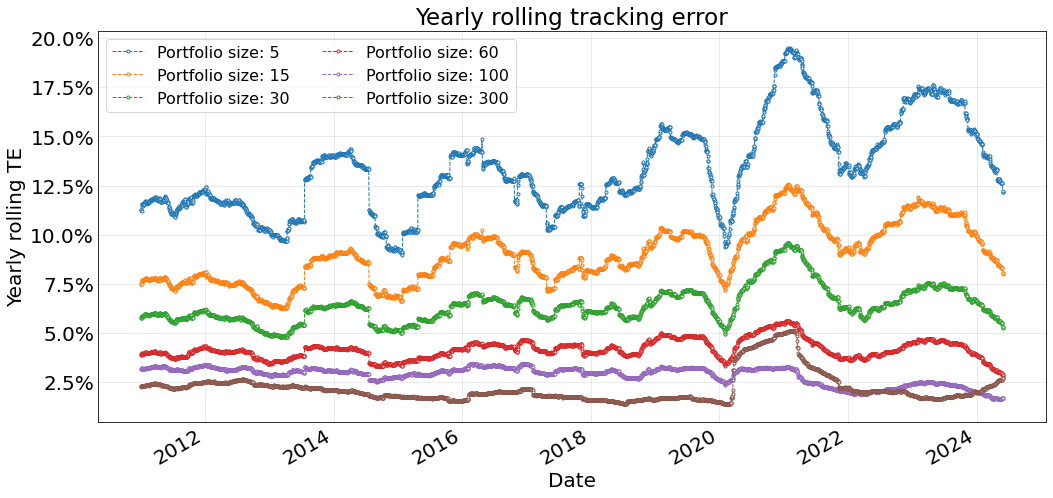

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(17, 8))

for k, weights in weights_dict.items():
    rolling_tracking_error = get_tracking_error(
        asset_returns=asset_returns.loc["2010":"2024"],
        index_returns=index_returns.loc["2010":"2024"],
        portfolio_weights_matrix=weights.loc["2010":"2024"]
    )
    rolling_tracking_error.plot(
        ls="--", marker=".", mfc="w", lw=1, ax=ax, label=f"Portfolio size: {k}"
    )

ax.grid(True, alpha=.3)
ax.legend(fontsize=16, ncol=2)
ax.set_title("Yearly rolling tracking error", fontsize=23);
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel("Yearly rolling TE", fontsize=20)
ax.set_xlabel("Date", fontsize=20)
ax.tick_params(axis='both', which='major', length=0, labelsize=20)

As expected, we clearly see the tracking error decreases with the size of the portfolio: the greater the number of elements the smaller the TE is. We notice significantly higher tracking errors at 2014, 2020 and 2023. The ones at 2020 and 2023 are caused by an increase in the volatility of the index, as shows below. The 2014 is probably due to the quality of the tracking not being very good, either because the PCA does not capture the dynamics or because of the covariance matrix used (in sample over the returns of the last 2 years) is significantly different from the matrix on the test period.

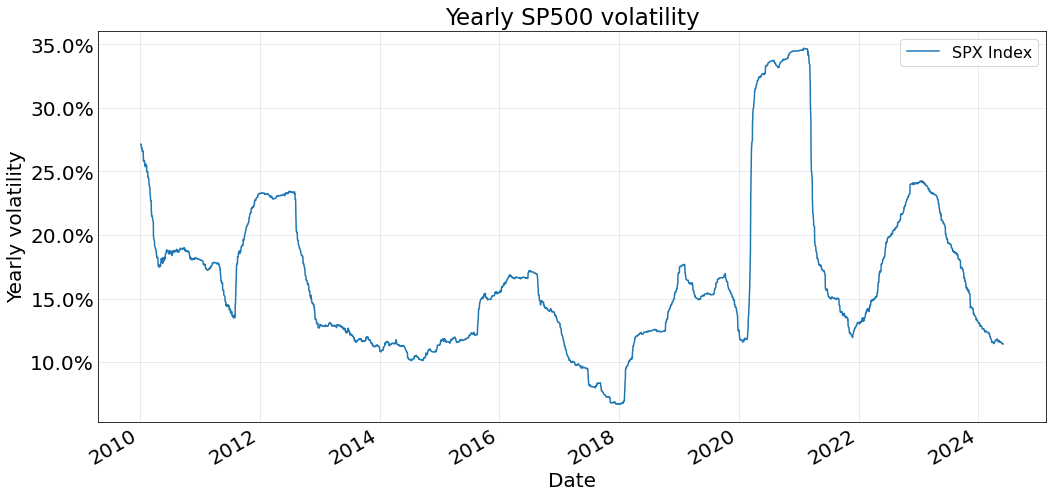

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(17, 8))

(100 * np.sqrt(252) * index_returns.rolling(252).std()).loc["2010":"2024"].plot(ax=ax)

ax.grid(True, alpha=.3)
ax.legend(fontsize=16, ncol=2)
ax.set_title("Yearly SP500 volatility", fontsize=23);
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel("Yearly volatility", fontsize=20)
ax.set_xlabel("Date", fontsize=20)
ax.tick_params(axis='both', which='major', length=0, labelsize=20)

## 4. Why is it "Naive"?

The approach we have used is far from desirable. Some reasons why:
1. PCA does not directly address the minimization of the tracking error.
2. PCA focuses on explaining the variance of the data, which may not be the best way to capture market movements.
3. Constraints: we have somewhat included the cardinality constraing on our portfolio construction but it was a far from elegant solution. What if we want to add more constraints? For intance: what if we want a portfolio computed at time $t+1$ to be derived from the portfolio at time $t$, limiting for example the number of assets that are allowed to change from $t$ to $t+1$? PCA is not suited for these constraints.

## 5. Conclusions

In this post we have briefly review the definition of Index Tracking and we have applied Principal Component Analysis to construct tracking portfolios. We have tested the methodology using the SP500 dataset, for which we have computed portfolios from different sizes.

Results show that we can achieve a 5% tracking error using portfolio sizes of 60 or more.

Finally, we have stated that PCA is probably the most naive way to approach the Index Tracking problem, since it has many caviats.

## References
* Benidis, K., Feng, Y., & Palomar, D. P. (2018). Optimization methods for financial index tracking: From theory to practice. Foundations and Trends® in Optimization, 3(3), 171-279.